(cmdstanpy_refitting)=
# Refitting CmdStanPy models with ArviZ

ArviZ is backend agnostic and therefore does not sample directly. In order to take advantage of algorithms that require refitting models several times, ArviZ uses {class}`~arviz.SamplingWrapper` to convert the API of the sampling backend to a common set of functions. Hence, functions like Leave Future Out Cross Validation can be used in ArviZ independently of the sampling backend used.

Below there is an example of `SamplingWrapper` usage for CmdStanPy extending {class}`arviz.CmdStanPySamplingWrapper` that already implements some default methods targeted to CmdStanPy.

Before starting, it is important to note that CmdStanPy cannot call the C++ functions it uses. Therefore, the **code** of the model must be slightly modified in order to be compatible with the cross validation refitting functions.

In [1]:
import arviz as az
from cmdstanpy import CmdStanModel, write_stan_json
import numpy as np
import matplotlib.pyplot as plt

For the example, we will use a linear regression model.

In [2]:
rng = np.random.default_rng(251)

xdata = np.linspace(0, 50, 100)
b0, b1, sigma = -2, 1, 3
ydata = rng.normal(loc=b1 * xdata + b0, scale=sigma)

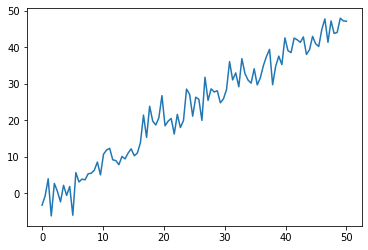

In [3]:
plt.plot(xdata, ydata)

Now we will write the Stan code, keeping in mind that it must be able to compute the pointwise log likelihood on excluded data, i.e., data that is not used to fit the model. Thus, the backbone of the code must look like the following:

```
data {
    data_for_fitting
    excluded_data
    ...
}
model {
    // fit against data_for_fitting
   ...
}
generated quantities {
    ....
    log_lik for data_for_fitting
    log_lik_excluded for excluded_data
}
```

In [4]:
with open("linreg_ex_model.stan", mode="r") as f:
    print(f.read())

data {
  // Define data for fitting
  int<lower=0> N;
  array[N] real x;
  array[N] real y;
  // Define excluded data. It will not be used when fitting.
  int<lower=0> N_ex;
  array[N_ex] real x_ex;
  array[N_ex] real y_ex;
}

parameters {
  real b0;
  real b1;
  real<lower=0> sigma_e;
}

model {
  b0 ~ normal(0, 10);
  b1 ~ normal(0, 10);
  sigma_e ~ normal(0, 10);
  for (i in 1:N) {
    y[i] ~ normal(b0 + b1 * x[i], sigma_e);  // use only data for fitting
  }

}

generated quantities {
    array[N] real log_lik;
    array[N_ex] real log_lik_ex;
    array[N] real y_hat;

    for (i in 1:N) {
        // calculate log likelihood and posterior predictive, there are
        // no restrictions on adding more generated quantities
        log_lik[i] = normal_lpdf(y[i] | b0 + b1 * x[i], sigma_e);
        y_hat[i] = normal_rng(b0 + b1 * x[i], sigma_e);
    }
    for (j in 1:N_ex) {
        // calculate the log likelihood of the excluded data given data_for_fitting
        log_lik_ex[j] = norma

In [5]:
model = CmdStanModel(stan_file="linreg_ex_model.stan")

In [6]:
data_dict = {
    "N": len(ydata),
    "y": ydata,
    "x": xdata,
    # No excluded data in initial fit
    "N_ex": 0,
    "x_ex": [],
    "y_ex": [],
}
sample_kwargs = {"iter_sampling": 1000, "chains": 4}
write_stan_json("linreg_ex_data.json", data_dict)
fit = model.sample(data="linreg_ex_data.json", **sample_kwargs)

19:13:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:05 - cmdstanpy - INFO - CmdStan done processing.


We have defined a dictionary `sample_kwargs` that will be passed to the `SamplingWrapper` in order to make sure that all
refits use the same sampler parameters. We will follow the same pattern with `az.from_cmdstanpy`. Here however, we are passing some arguments directly to `from_cmdstanpy`. We do this because we only want this data in `idata_orig`, not in every refit.

In [7]:
dims = {"y": ["time"], "x": ["time"], "log_likelihood": ["time"], "y_hat": ["time"]}
idata_kwargs = {
    "posterior_predictive": ["y_hat"],
    "log_likelihood": ["log_lik"],
    "dims": dims,
}
idata = az.from_cmdstanpy(
    posterior=fit, observed_data={"y": ydata}, constant_data={"x": xdata}, **idata_kwargs
)

We will create a subclass of {class}`~arviz.CmdStanPySamplingWrapper`. Therefore, instead of having to implement all functions required by {func}`~arviz.reloo` we only have to implement {func}`~arviz.CmdStanPySamplingWrapper.sel_observations`. As explained in its docs, it takes one argument which is the indices of the data to be excluded and returns `modified_observed_data` which is passed as `data` to `sampling` function of PyStan model and `excluded_observed_data` which is used to retrieve the log likelihood of the excluded data (as passing the excluded data would make no sense).

In [8]:
class LinearRegressionWrapper(az.CmdStanPySamplingWrapper):
    def sel_observations(self, idx):
        xdata = self.idata_orig.constant_data.x.values
        ydata = self.idata_orig.observed_data.y.values
        mask = np.full_like(xdata, True, dtype=bool)
        mask[idx] = False
        N_obs = len(mask)
        N_ex = np.sum(~mask)
        observations = {
            "N": N_obs - N_ex,
            "x": xdata[mask],
            "y": ydata[mask],
            "N_ex": N_ex,
            "x_ex": xdata[~mask],
            "y_ex": ydata[~mask],
        }
        return observations, "log_lik_ex"

In [9]:
loo_orig = az.loo(idata, pointwise=True, var_name="log_lik")
loo_orig

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -258.72     8.23
p_loo        3.17        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In this case, the Leave-One-Out Cross Validation (LOO-CV) approximation using [Pareto Smoothed Importance Sampling](https://arxiv.org/abs/1507.02646) (PSIS) works for all observations, so we will use modify `loo_orig` in order to make {func}`~arviz.reloo` believe that PSIS failed for some observations. This will also serve as a validation of our wrapper, as the PSIS LOO-CV already returned the correct value.

In [10]:
loo_orig.pareto_k[[13, 42, 56, 73]] = np.array([0.8, 1.2, 2.6, 0.9])

We initialize our sampling wrapper

In [11]:
idata_kwargs["log_likelihood"] = ["log_lik", "log_lik_ex"]
cmdstanpy_wrapper = LinearRegressionWrapper(
    model=model,
    idata_orig=idata,
    data_file="linreg_ex_data.json",
    sample_kwargs=sample_kwargs,
    idata_kwargs=idata_kwargs,
)

And eventually, we can use this wrapper to call `az.reloo`, and compare the results with the PSIS LOO-CV results.

In [12]:
loo_relooed = az.reloo(cmdstanpy_wrapper, loo_orig=loo_orig)

/home/oriol/Public/arviz/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
19:13:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:06 - cmdstanpy - INFO - CmdStan done processing.


19:13:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:07 - cmdstanpy - INFO - CmdStan done processing.


19:13:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:08 - cmdstanpy - INFO - CmdStan done processing.


19:13:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:08 - cmdstanpy - INFO - CmdStan done processing.


In [13]:
loo_relooed

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -258.73     8.23
p_loo        3.18        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [14]:
loo_orig

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -258.72     8.23
p_loo        3.17        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       96   96.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         2    2.0%
   (1, Inf)   (very bad)    2    2.0%